## REQUIREMENTS:

- FastAI installed
- Python 3.6 
- Data acquired from running "get_data.sh" (This should create 

### FastAI Transfer Learning on Stanford Cars Dataset with 1Cycle Learning Rate Policy

In [1]:
import PIL.Image

In [2]:
import os
import shutil

In [3]:
%%capture
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [4]:
import imageio

This part is taking the data which has already been organized from Sylvain's code:

In [5]:
if os.path.exists('./Adam-experiments'):
    os.chdir('./Adam-experiments')
if os.path.exists('./data/cars'):
    os.chdir('./data/cars/')
!ls

annots.csv  car_ims  car_ims.tgz  cars_annos.mat  models  tmp


Here we can view several images from the validation set.

We want to make sure it looks like the same class, but none of the images should be exactly the same.

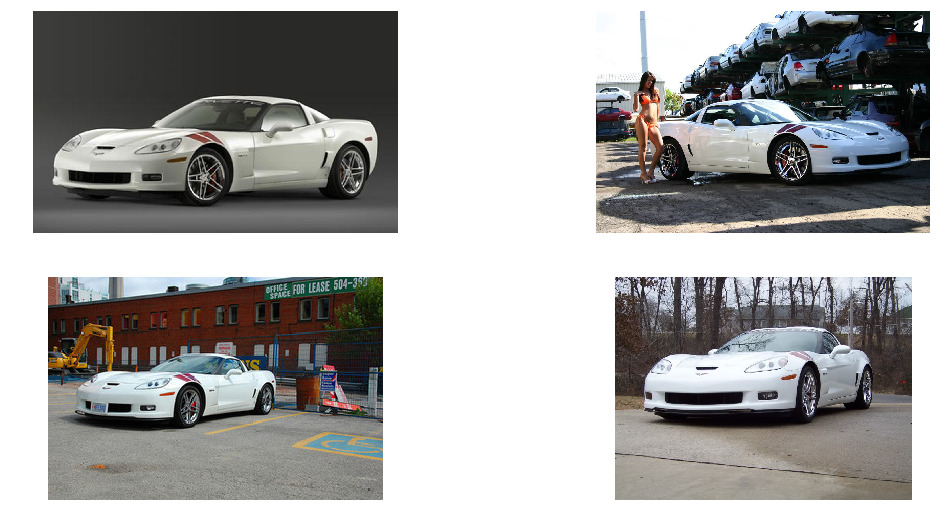

In [6]:
# Look at several images from the training set
annots = pd.read_csv('annots.csv')

# Get subset belonging to a random class 
rand_cl = rng.choice(196)
subset = annots.loc[annots['class']==rand_cl]

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2

tr_fn = np.array(subset.loc[:8145].sample(n=columns*rows)['fname'])

for i in range(1, columns*rows +1):
    img = imageio.imread(tr_fn[i-1])    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

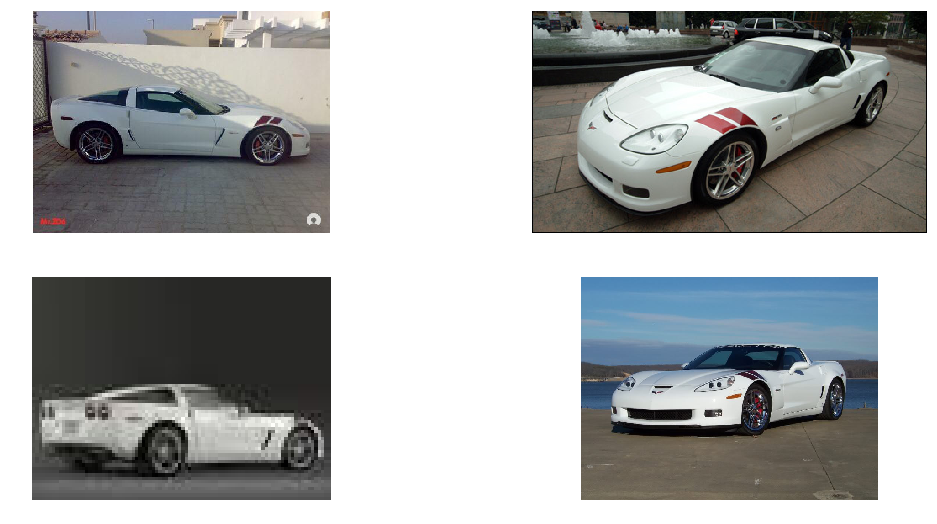

In [7]:
fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2

val_fn = np.array(subset.loc[8145:].sample(n=columns*rows)['fname'])

for i in range(1, columns*rows +1):
    img = imageio.imread(val_fn[i-1])    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [8]:
%%capture

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
#import skimage

Now we go back to the original directory:

In [9]:
if not os.path.exists('data'):
    os.chdir('../..')
!ls

callbacks.py	      lm_val_fns.py    README.md	 utils.py
data		      logs__0.txt      train_cifar10.py
fit_stanford_cars.py  prepare_data.py  train_model.py
get_data.sh	      __pycache__      train_rnn.py


Here I modified the default FastAI pipeline by enhancing the augmentations and increasing the dropout on the penultimate layer. Although I haven't extensively tested yet, the augmentations didn't seem to have much effect on overfitting compared to the dropout.

In [10]:
PATH = Path("data/cars/")
val_idxs = list(range(8144, 16185))

def get_data(sz, val_idxs, bs=128, arch=resnet50, aug_tfms=transforms_side_on,
            max_zoom=1.05):
    tfms = tfms_from_model(arch, sz,
            aug_tfms=aug_tfms,
            max_zoom=max_zoom)
    data = ImageClassifierData.from_csv(PATH, '', PATH/'annots.csv', bs, tfms,
            val_idxs=val_idxs, num_workers=8)
    return data

arch = resnet50
sz = 224
# Side on tranforms but increased a bit
aug_tfms = [RandomRotateZoom(deg=20, zoom=1.25, stretch=0.1)]
aug_tfms += [RandomLighting(0.1, 0.1)]
aug_tfms += [RandomFlip()]
#aug_tfms += [GoogleNetResize(targ_sz=sz)]

data = get_data(sz, val_idxs, bs=128, aug_tfms=aug_tfms, max_zoom=1.05)

Precomputation isn't really appropriate for this dataset and seems to just make it harder to train the entire network afterward.

In [11]:
# Without precompute set to False, this gives bad results.
learn = ConvLearner.pretrained(arch, data, ps=[0.5,0.5], precompute=False)

In [12]:
learn.opt_fn = optim.Adam

In [13]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [14]:
learn.freeze()

In [18]:
lrf=learn.lr_find(wds = 6e-2, use_wd_sched=True, start_lr=1e-05, end_lr=10)

 88%|████████▊ | 56/64 [01:35<00:14,  1.77s/it, loss=19.3]

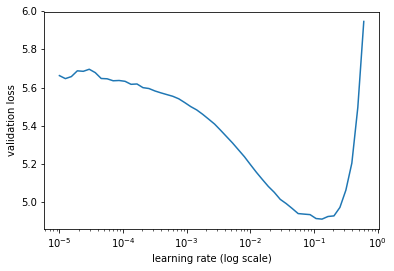

In [19]:
learn.sched.plot(n_skip=0,n_skip_end=3)

This code will barely fit in a 16 GB P100 GPU. So I use empty_cache() just to be safe.

In addition, running the learning rate finder takes up memory space so when testing a full model it is probably best to run the finders and then run the model all at once separately. 

In [15]:
#Use this to free more GPU memory after running training
torch.cuda.empty_cache()

In [16]:
result, ep_vals = learn.fit(3e-2, 1, cycle_len=10, use_clr_beta=(10, 10), wds=1e-1, use_wd_sched=True, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy                  
    0      4.138052   3.050125   0.255317  
    1      3.497534   2.683116   0.32098                   
    2      3.212607   2.666293   0.335655                  
    3      3.147193   2.559979   0.357045                  
    4      3.13518    2.572659   0.350578                  
    5      2.990789   2.404946   0.37943                   
    6      2.732167   2.178996   0.435021                  
    7      2.464353   2.001043   0.477553                  
    8      2.165286   1.846      0.512623                  
    9      1.967133   1.799699   0.525681                  



The model already shows signs of overfitting after training the head.

In [17]:
learn.unfreeze()
torch.cuda.empty_cache()

 86%|████████▌ | 55/64 [01:27<00:10,  1.21s/it, loss=6.57]

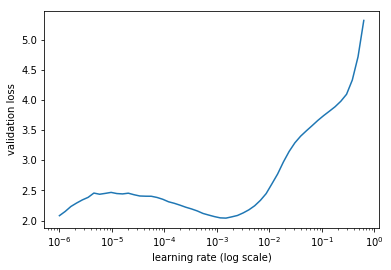

In [31]:
lrf=learn.lr_find(wds = 6e-2, use_wd_sched=True, start_lr=1e-06, end_lr=10)
learn.sched.plot(n_skip=0,n_skip_end=0)

In [18]:
torch.cuda.empty_cache()

In [19]:
lr2 = 1e-2

In [20]:
# Chose to divide the learning rate by less because the
# Cars dataset is probably not very similar to ImageNet overall.
lrs = np.array([lr2/30,lr2/3,lr2])

In [21]:
learn.fit(lrs, 1, cycle_len=20, use_clr_beta=(10, 10), wds=1e-1, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                  
    0      2.134156   1.815156   0.510633  
    1      1.775259   2.00809    0.452183                  
    2      1.638784   1.79379    0.510882                  
    3      1.512283   1.687096   0.540729                  
    4      1.443956   2.235773   0.416366                  
    5      1.388042   1.271252   0.650665                  
    6      1.302338   1.38411    0.617958                  
    7      1.275026   1.51704    0.580774                  
    8      1.292595   1.478234   0.597314                  
    9      1.155895   1.149328   0.685984                  
    10     1.015871   0.934281   0.742818                  
    11     0.839578   0.791103   0.777764                  
    12     0.679319   0.731927   0.793309                  
    13     0.562412   0.571135   0.834722                  
    14     0.456986   0.554414   0.841562                  
    15     0.362683   0.484584   0.861833               

[0.3968154961508967, 0.884840194072434]

This model still overfits a significant amount. More regularization should be added, perhaps by increasing dropout on the 2nd layer or even more weight decay. In addition, it appears that the learning rate could possibly go even higher because the training gets stuck around epochs 2-5. Perhaps a higher learning rate could coax it to "jump out" of the poor performing section earlier.

In [22]:
torch.cuda.empty_cache()

In [23]:
log_preds, y = learn.TTA()

In [24]:
probs = np.exp(log_preds)

In [25]:
avg_TTA = np.mean(probs, axis = 0)

In [26]:
preds = np.argmax(avg_TTA,axis=1)
targs = y

In [27]:
TTA_acc = (preds==targs).mean()
print(TTA_acc)

0.8966546449446586


TTA improved the accuracy very slightly, from  88.48% to 89.66%.

(array([52., 29., 33., 39., 40., 34., 46., 44., 40., 43., 45., 44., 38., 46., 42., 41., 42., 47., 44., 37.,
        38., 41., 77., 33., 38., 40., 41., 43., 41., 37., 43., 40., 38., 38., 47., 44., 42., 44., 40., 35.,
        45., 19., 49., 37., 45., 44., 44., 38., 31., 39., 48., 47., 44., 42., 48., 40., 46., 37., 43., 29.,
        46., 41., 43., 40., 38., 31., 37., 39., 51., 54., 43., 33., 46., 42., 44., 47., 41., 36., 47., 45.,
        48., 42., 43., 36., 31., 39., 38., 42., 48., 38., 39., 39., 45., 43., 33., 40., 35., 46., 41., 41.,
        32., 39., 46., 40., 38., 42., 42., 40., 31., 46., 40., 42., 40., 52., 43., 33., 37., 41., 37., 51.,
        40., 36., 42., 40., 42., 44., 53., 39., 41., 37., 42., 43., 28., 27., 48., 52., 31., 47., 36., 43.,
        37., 31., 40., 46., 42., 50., 38., 42., 46., 37., 46., 40., 44., 35., 44., 36., 45., 26., 46., 39.,
        35., 41., 38., 34., 46., 31., 43., 37., 36., 51., 44., 38., 41., 47., 44., 42., 45., 46., 44., 40.,
        44., 37., 50., 40., 

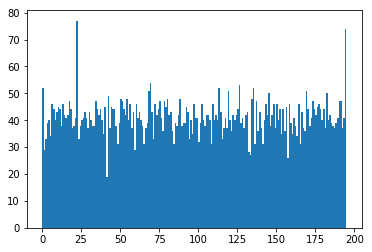

In [28]:
plt.hist(preds, bins=195)

We can see from the histogram that class 195 and class 22 are both especially overpredicted (class indices start at zero). I am not sure how to address this at this time.